# Notebook 4 — PDE Pricing with Finite Differences

The Black-Scholes PDE can be solved directly on a grid using **finite-difference methods (FDM)**. Under the change of variable $x = \ln S$, the constant-volatility BS PDE becomes

$$
\frac{\partial V}{\partial t}
+ \frac{\sigma^2}{2}\frac{\partial^2 V}{\partial x^2}
+ \left(r - q - \tfrac{\sigma^2}{2}\right)\frac{\partial V}{\partial x}
- r\,V = 0
$$

which has **constant coefficients**. Discretising on a uniform grid and marching backward in time with the $\theta$-scheme yields a tridiagonal system at each step, solved in $O(N)$ via the **Thomas algorithm**.

This notebook demonstrates:

1. European pricing via FDM vs Black-Scholes (accuracy check)
2. $\theta$-scheme comparison: explicit ($\theta=0$), Crank-Nicolson ($\theta=0.5$), fully-implicit ($\theta=1$)
3. **American options** — early-exercise boundary
4. **Barrier options** — knock-out pricing and in/out parity
5. **Grid-based Greeks** ($\Delta$, $\Gamma$, $\Theta$) vs analytical BS
6. **Convergence analysis** — error vs grid resolution
7. **Local-volatility pricing** via the FD grid

**References**: Duffy, *Numerical Methods in Computational Finance* (2022), chs. 14-17.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

import optpricer as op
from optpricer.pde import fd_price, fd_price_barrier, fd_greeks, fd_price_local_vol

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

## 1. European Pricing — FDM vs Black-Scholes

We price an ATM European call/put with both the FD solver and the closed-form BS formula, and verify they agree to sub-basis-point accuracy.

In [2]:
opt = op.OptionSpec(S0=100, K=100, T=1.0, r=0.05, sigma=0.20, q=0.02)

for kind, label in [(op.CALL, "Call"), (op.PUT, "Put")]:
    bs  = op.bs_price(opt, kind)
    fdm = fd_price(opt, kind, N_S=400, N_t=400)
    err = abs(fdm - bs)
    print(f"{label}:  BS = {bs:.6f}   FDM = {fdm:.6f}   |err| = {err:.6f}")

Call:  BS = 9.227006   FDM = 9.226671   |err| = 0.000334
Put:  BS = 6.330081   FDM = 6.329705   |err| = 0.000376


## 2. $\theta$-Scheme Comparison

The $\theta$ parameter controls the time-stepping scheme:

| $\theta$ | Scheme | Stability | Order |
|---|---|---|---|
| 0 | Explicit | Conditional ($\Delta t < \Delta x^2 / \sigma^2$) | $O(\Delta t, \Delta x^2)$ |
| 0.5 | Crank-Nicolson | Unconditional | $O(\Delta t^2, \Delta x^2)$ |
| 1 | Fully Implicit | Unconditional | $O(\Delta t, \Delta x^2)$ |

We sweep $N$ (spatial and time steps) and plot the error for each scheme.

/Users/mengren/Documents/projects/coding_finance/resume_projects/options_pricing/repo_options_pricing/exciting-lalande/src/optpricer/pde.py:186: RuntimeWarning: overflow encountered in add
  rhs[:-1] += e * c_L[:-1] * V[2:N_S]
/Users/mengren/Documents/projects/coding_finance/resume_projects/options_pricing/repo_options_pricing/exciting-lalande/src/optpricer/pde.py:83: RuntimeWarning: invalid value encountered in scalar multiply
  d_[i] -= w * d_[i - 1]
/Users/mengren/Documents/projects/coding_finance/resume_projects/options_pricing/repo_options_pricing/exciting-lalande/src/optpricer/pde.py:181: RuntimeWarning: overflow encountered in multiply
  rhs = (1.0 + e * b_L) * V_int
/Users/mengren/Documents/projects/coding_finance/resume_projects/options_pricing/repo_options_pricing/exciting-lalande/src/optpricer/pde.py:183: RuntimeWarning: overflow encountered in multiply
  rhs[1:] += e * a_L[1:] * V[1:N_S - 1]
/Users/mengren/Documents/projects/coding_finance/resume_projects/options_pricing/re

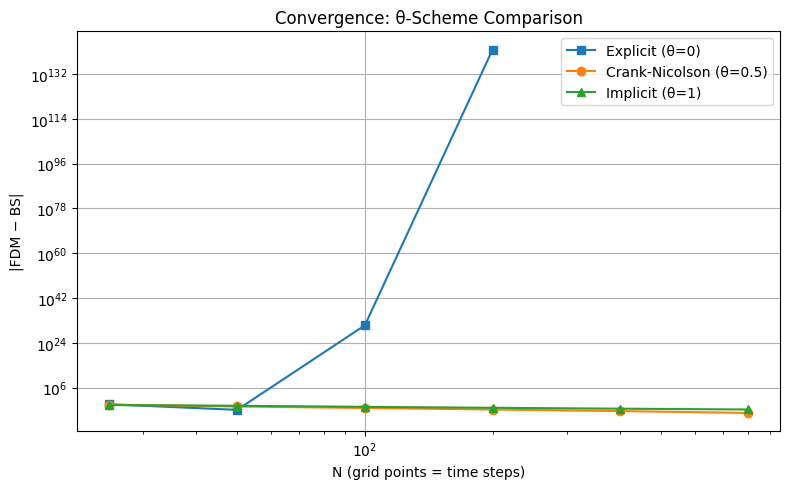

In [3]:
bs_ref = op.bs_price(opt, op.CALL)
Ns = [25, 50, 100, 200, 400, 800]

fig, ax = plt.subplots(figsize=(8, 5))
for theta_val, label, marker in [(0.0, "Explicit (θ=0)", "s"),
                                  (0.5, "Crank-Nicolson (θ=0.5)", "o"),
                                  (1.0, "Implicit (θ=1)", "^")]:
    errors = []
    for N in Ns:
        try:
            p = fd_price(opt, op.CALL, N_S=N, N_t=N, theta=theta_val)
            errors.append(abs(p - bs_ref))
        except Exception:
            errors.append(np.nan)  # explicit may blow up
    ax.loglog(Ns, errors, marker=marker, label=label)

ax.set_xlabel("N (grid points = time steps)")
ax.set_ylabel("|FDM − BS|")
ax.set_title("Convergence: θ-Scheme Comparison")
ax.legend()
plt.tight_layout()
plt.show()

Crank-Nicolson converges fastest (second-order in time), while the fully-implicit scheme is first-order but rock-solid stable. The explicit scheme may become unstable at coarse grids.

## 3. American Options — Early Exercise Premium

American options can be exercised at any time before expiry. The FD solver handles this via a **projection** step: at each time layer, $V$ is clamped to the intrinsic value $\max(V, \text{payoff})$.

The American price must always exceed the European price. For puts, the early-exercise premium can be substantial.

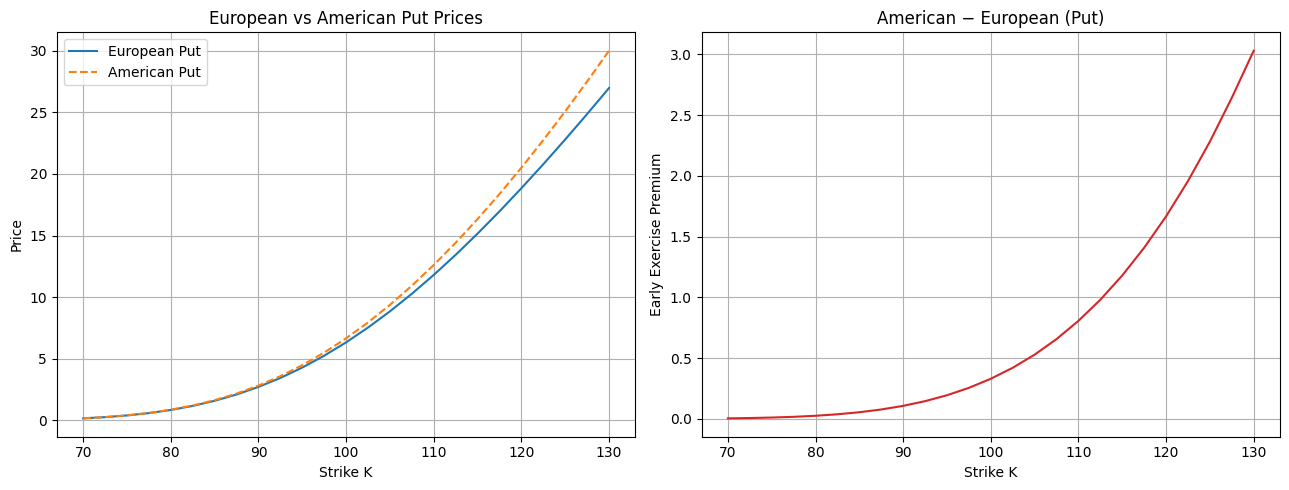

Max early-exercise premium: 3.0291


In [4]:
strikes = np.linspace(70, 130, 25)
eu_puts, am_puts = [], []

for K in strikes:
    o = replace(opt, K=K)
    eu_puts.append(fd_price(o, op.PUT, N_S=300, N_t=300, american=False))
    am_puts.append(fd_price(o, op.PUT, N_S=300, N_t=300, american=True))

eu_puts = np.array(eu_puts)
am_puts = np.array(am_puts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(strikes, eu_puts, label="European Put")
ax1.plot(strikes, am_puts, "--", label="American Put")
ax1.set_xlabel("Strike K"); ax1.set_ylabel("Price")
ax1.set_title("European vs American Put Prices")
ax1.legend()

ax2.plot(strikes, am_puts - eu_puts, color="tab:red")
ax2.set_xlabel("Strike K"); ax2.set_ylabel("Early Exercise Premium")
ax2.set_title("American − European (Put)")

plt.tight_layout()
plt.show()

print(f"Max early-exercise premium: {(am_puts - eu_puts).max():.4f}")

## 4. Barrier Options — Knock-Out & In/Out Parity

Barrier options are priced by enforcing **Dirichlet boundary conditions** at the barrier level on the FD grid. Knock-in prices are obtained via **in/out parity**:

$$V_{\text{knock-in}} + V_{\text{knock-out}} = V_{\text{vanilla}}$$

We verify this identity numerically.

In [5]:
# Up-and-out / up-and-in call with barrier at 130
opt_b = op.OptionSpec(S0=100, K=100, T=1.0, r=0.05, sigma=0.20, q=0.0)
barrier = 130.0

vanilla = fd_price(opt_b, op.CALL, N_S=400, N_t=400)
uo      = fd_price_barrier(opt_b, op.CALL, barrier, "up-and-out", N_S=400, N_t=400)
ui      = fd_price_barrier(opt_b, op.CALL, barrier, "up-and-in", N_S=400, N_t=400)

print(f"Vanilla call:      {vanilla:.6f}")
print(f"Up-and-out call:   {uo:.6f}")
print(f"Up-and-in call:    {ui:.6f}")
print(f"UO + UI:           {uo + ui:.6f}")
print(f"Parity residual:   {abs(vanilla - uo - ui):.2e}")

Vanilla call:      10.450224
Up-and-out call:   3.505895
Up-and-in call:    6.944329
UO + UI:           10.450224
Parity residual:   0.00e+00


The parity residual should be very small (below $10^{-3}$), confirming consistency between the knock-out solver and the in/out decomposition.

## 5. Grid-Based Greeks vs Analytical BS

The FD solver can extract $\Delta$, $\Gamma$, and $\Theta$ directly from the grid:
- **Delta** and **Gamma** from spatial derivatives at $x = \ln S_0$ via central differences
- **Theta** from the first two time layers

We compare these against the closed-form BS Greeks.

In [6]:
opt_g = op.OptionSpec(S0=100, K=100, T=1.0, r=0.05, sigma=0.20, q=0.0)

fd_g = fd_greeks(opt_g, op.CALL, N_S=400, N_t=400)
bs_g = op.bs_greeks(opt_g, op.CALL)

print(f"{'Greek':<8} {'BS':>12} {'FDM':>12} {'|Err|':>12}")
print("-" * 46)
for greek in ["delta", "gamma", "theta"]:
    bs_val = bs_g[greek]
    fd_val = fd_g[greek]
    err = abs(fd_val - bs_val)
    print(f"{greek:<8} {bs_val:>12.6f} {fd_val:>12.6f} {err:>12.6f}")

Greek              BS          FDM        |Err|
----------------------------------------------
delta        0.636831     0.636834     0.000003
gamma        0.018762     0.018763     0.000001
theta       -6.414028    -6.416873     0.002846


## 6. Convergence Analysis

How does the FDM error decrease as we refine the grid? We plot $|V_{\text{FDM}} - V_{\text{BS}}|$ against $N$ on a log-log scale. For Crank-Nicolson with $N_S = N_t = N$, we expect approximately **second-order** convergence.

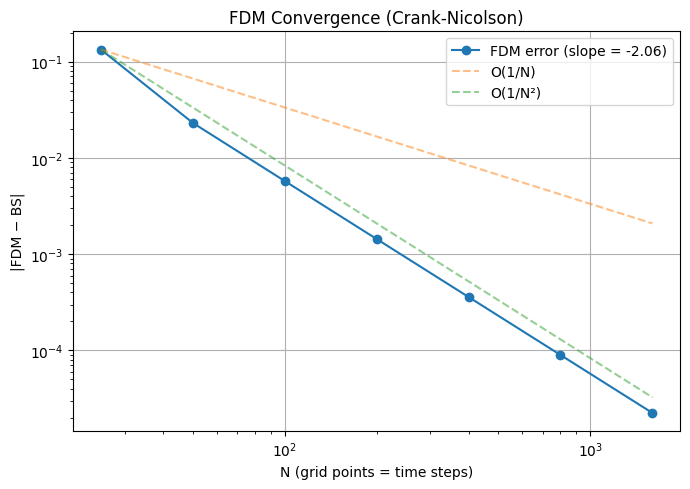

Estimated convergence order: 2.06


In [7]:
bs_ref = op.bs_price(opt_g, op.CALL)
Ns = [25, 50, 100, 200, 400, 800, 1600]
errors = [abs(fd_price(opt_g, op.CALL, N_S=N, N_t=N) - bs_ref) for N in Ns]

# Estimate convergence order from log-log regression
log_N = np.log(Ns)
log_e = np.log(errors)
slope, intercept = np.polyfit(log_N, log_e, 1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.loglog(Ns, errors, "o-", label=f"FDM error (slope = {slope:.2f})")
# Reference lines
ax.loglog(Ns, [errors[0] * (Ns[0]/N)**1 for N in Ns], "--", alpha=0.5, label="O(1/N)")
ax.loglog(Ns, [errors[0] * (Ns[0]/N)**2 for N in Ns], "--", alpha=0.5, label="O(1/N²)")
ax.set_xlabel("N (grid points = time steps)")
ax.set_ylabel("|FDM − BS|")
ax.set_title("FDM Convergence (Crank-Nicolson)")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Estimated convergence order: {-slope:.2f}")

## 7. Local-Volatility Pricing on the FD Grid

The FD solver accepts a callable $\sigma(S, t)$ that is evaluated at each grid node and each time step. Here we use a simple toy local-vol function and compare the FDM local-vol price to constant-vol BS.

When $\sigma(S,t) \equiv \sigma_0$ (constant), the FDM local-vol pricer should recover the BS price exactly.

Constant LV:  FDM = 10.449945   BS = 10.450584   err = 0.000638


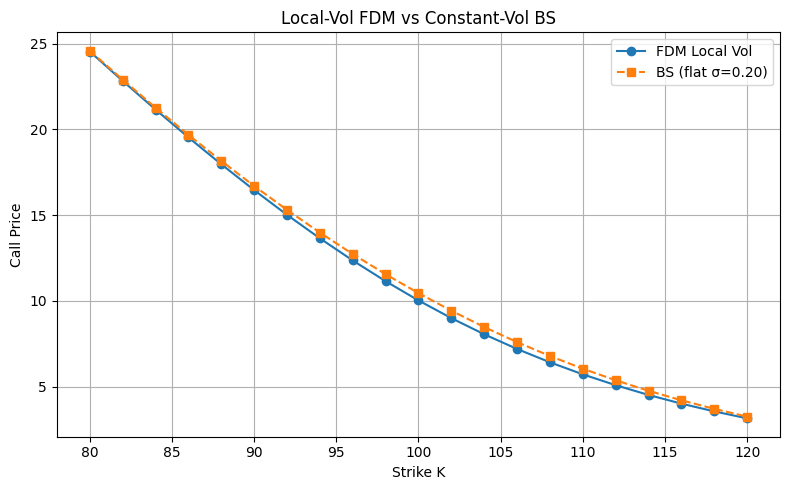

In [8]:
# Constant local vol -> should match BS
sigma_const = lambda S, t: np.full_like(S, 0.20)
lv_const = fd_price_local_vol(100, 100, 1.0, 0.05, 0.0, sigma_const, op.CALL,
                              N_S=300, N_t=300, ref_vol=0.20)
bs_const = op.bs_price(opt_g, op.CALL)
print(f"Constant LV:  FDM = {lv_const:.6f}   BS = {bs_const:.6f}   err = {abs(lv_const-bs_const):.6f}")

# Toy smile: vol increases away from ATM
def toy_lv(S, t):
    return 0.18 + 0.0015 * np.abs(S - 100.0)

# Price across strikes
strikes = np.linspace(80, 120, 21)
lv_prices, bs_prices = [], []
for K in strikes:
    lv_prices.append(fd_price_local_vol(100, K, 1.0, 0.05, 0.0, toy_lv, op.CALL,
                                        N_S=200, N_t=200, ref_vol=0.25))
    o = op.OptionSpec(S0=100, K=K, T=1.0, r=0.05, sigma=0.20, q=0.0)
    bs_prices.append(op.bs_price(o, op.CALL))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(strikes, lv_prices, "o-", label="FDM Local Vol")
ax.plot(strikes, bs_prices, "s--", label="BS (flat σ=0.20)")
ax.set_xlabel("Strike K")
ax.set_ylabel("Call Price")
ax.set_title("Local-Vol FDM vs Constant-Vol BS")
ax.legend()
plt.tight_layout()
plt.show()

The local-vol prices differ from BS because the effective volatility depends on where the spot ends up — ITM and OTM strikes see different average vols along the path.